# **1. Importing Libraries**

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
import warnings
warnings.filterwarnings('ignore')
import joblib

# **2. Loading and Inspecting Data**

In [92]:
data = pd.read_csv('telecommunication.csv')

In [93]:
data.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         400000 non-null  object 
 1   REGION          242480 non-null  object 
 2   TENURE          400000 non-null  object 
 3   MONTANT         259723 non-null  float64
 4   FREQUENCE_RECH  259723 non-null  float64
 5   REVENUE         265337 non-null  float64
 6   ARPU_SEGMENT    265337 non-null  float64
 7   FREQUENCE       265337 non-null  float64
 8   DATA_VOLUME     203146 non-null  float64
 9   ON_NET          254181 non-null  float64
 10  ORANGE          233683 non-null  float64
 11  TIGO            160614 non-null  float64
 12  ZONE1           31690 non-null   float64
 13  ZONE2           25513 non-null   float64
 14  MRG             400000 non-null  object 
 15  REGULARITY      400000 non-null  int64  
 16  TOP_PACK        232671 non-null  object 
 17  FREQ_TOP_P

# **3. Tenure Mapping and Feature Engineering**

In [95]:
# Mapper for TENURE
mapper = {
    "K > 24 month": (24 + 27)/2, "I 18-21 month": (18+21)/2, "G 12-15 month": (12+15)/2,
    "H 15-18 month": (15+18)/2, "J 21-24 month": (21+24)/2, "F 9-12 month": (9+12)/2,
    "D 3-6 month": (3+6)/2, "E 6-9 month": (6+9)/2
}

In [96]:
data['TENURE_LE'] = data['TENURE'].replace(mapper)
data['TENURE/REGULARITY'] = data['TENURE_LE'] / data['REGULARITY']
data['TENURE_REGULARITY'] = data['TENURE_LE'] * data['REGULARITY']
data['REVENUE-MONTANT'] = data['REVENUE'] - data['MONTANT']
data['REVENUE/MONTANT'] = data['REVENUE'] / data['MONTANT']
data['TENURE/FREQUENCE_RECH'] = data['TENURE_LE'] / data['FREQUENCE_RECH']


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                400000 non-null  object 
 1   REGION                 242480 non-null  object 
 2   TENURE                 400000 non-null  object 
 3   MONTANT                259723 non-null  float64
 4   FREQUENCE_RECH         259723 non-null  float64
 5   REVENUE                265337 non-null  float64
 6   ARPU_SEGMENT           265337 non-null  float64
 7   FREQUENCE              265337 non-null  float64
 8   DATA_VOLUME            203146 non-null  float64
 9   ON_NET                 254181 non-null  float64
 10  ORANGE                 233683 non-null  float64
 11  TIGO                   160614 non-null  float64
 12  ZONE1                  31690 non-null   float64
 13  ZONE2                  25513 non-null   float64
 14  MRG                    400000 non-nu

# **4. Dropping Irrelevant Features**

In [98]:
irrelevant_features = ['user_id', 'TENURE', 'TOP_PACK']
data = data.drop(columns=irrelevant_features)

# **5. Defining Categorical and Numerical Features**

In [99]:
# Defining categorical and numerical features
cat_feat = data.select_dtypes(exclude=np.number).columns
num_feat = data.select_dtypes(include=[np.number]).columns



# **6. Handling Missing Values**

In [100]:
# Fill missing values for numerical and categorical features
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

In [101]:
data[num_feat] = num_imputer.fit_transform(data[num_feat])
data[cat_feat] = cat_imputer.fit_transform(data[cat_feat])

# **7. Summary Statistics**

In [102]:
# Summary statistics for numerical features
summary_stats = data.describe()
summary_stats

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN,TENURE_LE,TENURE/REGULARITY,TENURE_REGULARITY,REVENUE-MONTANT,REVENUE/MONTANT,TENURE/FREQUENCE_RECH
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.00000,400000.000000,400000.000000,400000.000000,400000.00000,400000.000000,400000.000000
mean,5522.971346,11.503733,5505.487757,1835.167658,13.951835,3369.763441,275.917586,95.532927,23.134608,7.874282,7.187003,28.046502,9.254209,0.18711,25.074600,4.452524,704.591434,96.36497,1.030673,7.624489
std,5720.859508,10.697351,5844.388871,1948.125688,11.956196,8752.618996,696.386587,156.484600,39.960208,10.032222,6.809694,22.282773,9.385172,0.39000,2.014202,7.183268,564.182689,1177.26362,0.492684,6.736170
min,20.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,4.500000,0.080357,4.500000,-192968.00000,0.000667,0.107143
25%,2000.000000,4.000000,1900.000000,633.000000,6.000000,240.000000,12.000000,20.000000,11.000000,7.874282,7.187003,6.000000,4.000000,0.00000,25.500000,0.500000,153.000000,0.00000,1.000000,2.550000
50%,5522.971346,11.503733,5505.487757,1835.167658,13.951835,3369.763441,209.000000,95.532927,23.134608,7.874282,7.187003,24.000000,9.254209,0.00000,25.500000,1.026316,612.000000,96.36497,1.030673,7.624489
75%,5522.971346,11.503733,5505.487757,1835.167658,13.951835,3369.763441,275.917586,95.532927,23.134608,7.874282,7.187003,51.000000,9.254209,0.00000,25.500000,4.250000,1275.000000,96.36497,1.030673,7.624489
max,226550.000000,133.000000,233413.000000,77804.000000,91.000000,934576.000000,45011.000000,6788.000000,2758.000000,1657.000000,1011.000000,62.000000,629.000000,1.00000,25.500000,25.500000,1581.000000,83692.00000,148.100000,25.500000


# **8. Correlation Heatmap**

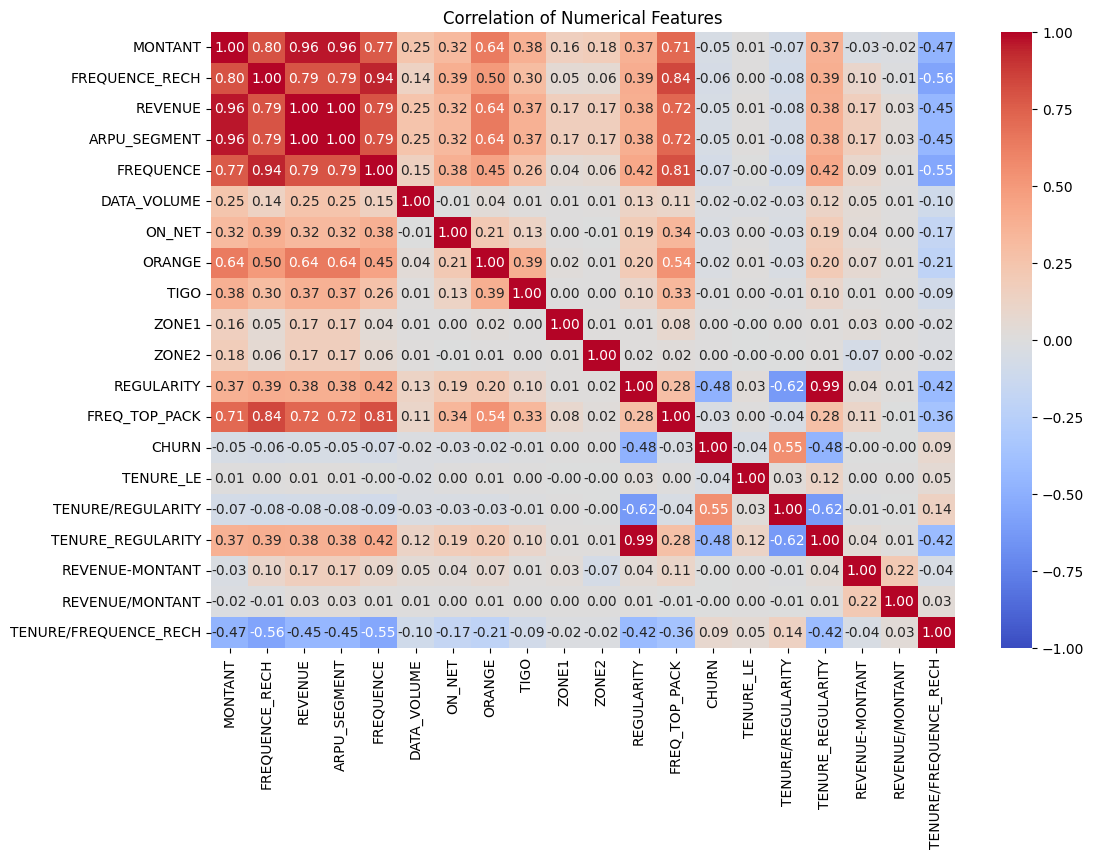

In [103]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = data[num_feat].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Numerical Features')
plt.show()


# **9. Churn Rate Analysis**

In [104]:
# Churn rate
churn_rate = data['CHURN'].value_counts(normalize=True) * 100
print(churn_rate)



CHURN
0.0    81.289
1.0    18.711
Name: proportion, dtype: float64


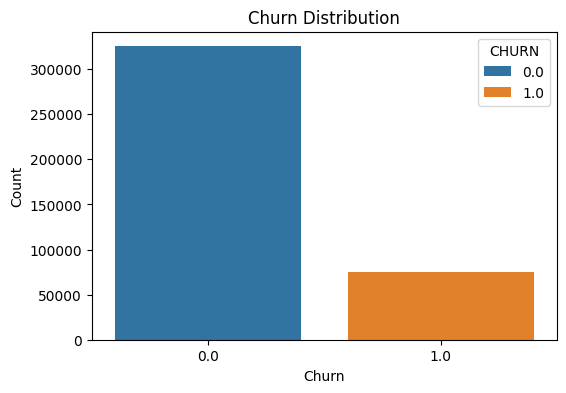

In [106]:
# Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='CHURN', data=data,hue='CHURN')
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


# **10. One-Hot Encoding Categorical Features**

In [107]:
# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_cat_feat = pd.DataFrame(encoder.fit_transform(data[cat_feat]), columns=encoder.get_feature_names_out(cat_feat))
data = data.drop(columns=cat_feat).join(encoded_cat_feat)


# **11. Balancing Classes**

In [108]:
# Separate the classes
class_0 = data[data['CHURN'] == 0.0]
class_1 = data[data['CHURN'] == 1.0]

# Sample 74,000 from each class
sampled_class_0 = class_0.sample(n=74000, random_state=42)
sampled_class_1 = class_1.sample(n=74000, random_state=42)

# Combine the samples
sampled_df = pd.concat([sampled_class_0, sampled_class_1])

# Shuffle the combined dataset
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)



In [109]:
sampled_df.CHURN.value_counts()

,count
CHURN,
0.0,74000
1.0,74000


# **12. Defining Features and Target**

In [110]:
X = sampled_df.drop(columns=['CHURN'])
y = sampled_df['CHURN']




In [111]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# **13. Training the Model**

In [114]:
model = GradientBoostingClassifier(n_estimators=500,random_state=42)
model.fit(X_train,y_train)

GradientBoostingClassifier(n_estimators=500, random_state=42)

# **14. Evaluating the Model**

In [115]:
y_pred = model.predict(X_test)
print("Random Undersampling Results:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Random Undersampling Results:
[[17810  4394]
 [ 2516 19680]]
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84     22204
         1.0       0.82      0.89      0.85     22196

    accuracy                           0.84     44400
   macro avg       0.85      0.84      0.84     44400
weighted avg       0.85      0.84      0.84     44400



In [116]:
joblib.dump(model,'gbt_model.pkl')

['gbt_model.pkl']

In [117]:
model = joblib.load('gbt_model.pkl')

In [118]:
y_pred_ = model.predict_proba(X_test)[:,1]

In [119]:
print(roc_auc_score(y_test,y_pred_))

0.9142580627143271
